# Model Prototyping for EnhancementGAN

In [3]:
import cv2
import glob
import os
import numpy as np
import torch

## Download a sample image

In [4]:
%%bash
mkdir -p Original
#wget -O Original/sample.jpg https://github.com/quic/qidk/raw/master/VisionSolution3-ImageEnhancement/enhancement/src/main/assets/Sample1.jpg
#cp ~/code/qnn/qidk/Solutions/VisionSolution3-ImageEnhancement/./enhancement/src/main/assets/sample.jpg . 

## Pre-processing data

In [5]:
def convert_image(img, source, target):
    if source == 'array':
        img = torch.from_numpy(img.transpose((2, 0, 1))).contiguous()#chw
        img = img.to(dtype=torch.float32).div(255) 
    elif source == '[0, 1]':
        img = torch.clamp(img, 0, 1)  # useful to post-process output of models that can overspill
    
    if target == '[0, 1]':
        pass  # already in [0, 1]
    return img

In [6]:
def preprocess(img_path):
        l_img = cv2.resize(cv2.imread(img_path),[320,240],interpolation=cv2.INTER_CUBIC)
        l_img = cv2.cvtColor(l_img, cv2.COLOR_BGR2RGB)
        ll_img = np.array(l_img, dtype='float32')
        ll_img = np.uint8(np.clip(ll_img, 0., 255.))  # this is to simulate matlab's imwrite operation
        ll_img = np.uint8(ll_img)
        ll_img = convert_image(ll_img, source='array', target='[0, 1]')
        img_ll = ll_img.cpu().detach().numpy()
        model_input = img_ll.astype(np.float32)
        return model_input

## Post-processing data

In [7]:
def post_process_enhanced(img):
    img = np.fromfile(img, np.float32)
    img = img.reshape((3, 240, 320)).astype(np.float32)
    img = np.clip((img+1)/2 * 255. , 0., 255.)
    img = np.uint8(img)
    img = img.transpose(1, 2, 0)#hwc
    return img

## Prepare the data for the model

In [8]:
%%bash
mkdir -p raw

In [9]:
for image in os.listdir('Original'):
    img_path = 'Original/'+image
    raw_input = preprocess(img_path)
    fid = open("raw/"+str(image[:-4])+ ".raw", 'wb')
    raw_input.tofile(fid)
    fid.close()

In [10]:
%%bash
find . -name *.raw > list.txt

# Setting up Artifacts Paths

<ul>
    <li>Before running below block set 'QNN_SDK_ROOT' to your qnn folder path</li>
    <li>Also, set 'DEVICE_ID' to your device-id. Use command "adb devices" to get devices names.</li>
    </ul>

In [15]:
## Give appropriate permission to the directory "FOLDER_WITH_ARTIFACTS" you are working with

os.environ['QNN_SDK_ROOT']="/opt/qcom/aistack/qairt/2.25.0.240728"#set up your snpe path here.
#os.environ['QNN_SDK_ROOT']="/local/mnt/workspace/sdks/qnn/qnn-v2.9.0.230327191003_53330"#set up your snpe path here.
os.environ['RAW_FILE_FOLDER']="raw"
os.environ['FP32']="../model_libs/FP_32/aarch64-android/libenlighten_opt.so"
os.environ['INT8']="../model_libs/INT_8/aarch64-android/libenlighten_opt_quantized.so"
os.environ['TARGET_INPUT_LIST']="list.txt"
os.environ['ONDEVICE_FOLDER']="EnhancementGAN"
os.environ['DEVICE_HOST']="localhost"
os.environ['DEVICE_ID']="503bd507" #fill your device-id. Use command "adb devices" to get devices names. example :"e18d5d0"
os.environ['QNN_TARGET_ARCH']="aarch64-android"
os.environ['QNN_TARGET_CPU']="libQnnCpu.so"
os.environ['QNN_TARGET_HTP']="libQnnHtp.so"

# Creating ON_Device Folder 

In [16]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL shell "mkdir -p /data/local/tmp/$ONDEVICE_FOLDER"

# Pushing Backends and Libraries

In [20]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL push ${QNN_SDK_ROOT}/lib/$QNN_TARGET_ARCH/$QNN_TARGET_CPU /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push ${QNN_SDK_ROOT}/lib/$QNN_TARGET_ARCH/$QNN_TARGET_HTP /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push ${QNN_SDK_ROOT}/lib/hexagon-v75/unsigned/*.so /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push ${QNN_SDK_ROOT}/lib/$QNN_TARGET_ARCH/*.so /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push $FP32 /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push $INT8 /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push ${QNN_SDK_ROOT}/bin/$QNN_TARGET_ARCH/ /data/local/tmp/$ONDEVICE_FOLDER

/opt/qcom/aistack/qairt/2.25.0.240728/lib/aarch64-android/libQnnCpu.so: 1 file pushed. 36.2 MB/s (5426536 bytes in 0.143s)
/opt/qcom/aistack/qairt/2.25.0.240728/lib/aarch64-android/libQnnHtp.so: 1 file pushed. 33.6 MB/s (1816888 bytes in 0.052s)
/opt/qcom/aistack/qairt/2.25.0.240728/lib/hexagon-v75/unsigned/libCalculator_skel.so: 1 file pushed. 1.3 MB/s (7696 bytes in 0.006s)
/opt/qcom/aistack/qairt/2.25.0.240728/lib/hexagon-v75/unsigned/libQnnHtpV75Skel.so: 1 file pushed. 36.2 MB/s (8072988 bytes in 0.213s)
/opt/qcom/aistack/qairt/2.25.0.240728/lib/hexagon-v75/unsigned/libQnnHtpV75.so: 1 file pushed. 38.1 MB/s (9665636 bytes in 0.242s)
/opt/qcom/aistack/qairt/2.25.0.240728/lib/hexagon-v75/unsigned/libQnnSaver.so: 1 file pushed. 25.6 MB/s (318044 bytes in 0.012s)
/opt/qcom/aistack/qairt/2.25.0.240728/lib/hexagon-v75/unsigned/libQnnSystem.so: 1 file pushed. 8.7 MB/s (75544 bytes in 0.008s)
/opt/qcom/aistack/qairt/2.25.0.240728/lib/hexagon-v75/unsigned/libSnpeHtpV75Skel.so: 1 file pushed

# Pushing Input list and data to the device

In [21]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL push raw /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push $TARGET_INPUT_LIST /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push ../output/lib_graph_prepare_from_int8_x86.serialized.bin /data/local/tmp/$ONDEVICE_FOLDER

raw/: 1 file pushed. 32.2 MB/s (921600 bytes in 0.027s)
list.txt: 1 file pushed. 0.0 MB/s (18 bytes in 0.006s)
../output/lib_graph_prepare_from_int8_x86.serialized.bin: 1 file pushed. 35.6 MB/s (9224704 bytes in 0.247s)


# Push the qnn-net-run tool:

In [23]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL push ${QNN_SDK_ROOT}/bin/$QNN_TARGET_ARCH/qnn-net-run /data/local/tmp/$ONDEVICE_FOLDER

/opt/qcom/aistack/qairt/2.25.0.240728/bin/aarch64-android/qnn-net-run: 1 file pushed. 34.9 MB/s (1902512 bytes in 0.052s)


# Now set up the environment on device:

## qnn-net-run : CPU backend

In [24]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL shell "export LD_LIBRARY_PATH=/data/local/tmp/$ONDEVICE_FOLDER && \ 
                     cd /data/local/tmp/$ONDEVICE_FOLDER && \
                     ./qnn-net-run --backend libQnnCpu.so --model libenlighten_opt.so --input_list list.txt"

/system/bin/sh:  : inaccessible or not found


qnn-net-run pid:12660


## qnn-net-run : HTP backend

In [25]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL shell "export LD_LIBRARY_PATH=/data/local/tmp/$ONDEVICE_FOLDER && \
                     export ADSP_LIBRARY_PATH='/data/local/tmp/$ONDEVICE_FOLDER' && \
                     cd /data/local/tmp/$ONDEVICE_FOLDER && \
                     ./qnn-net-run --backend libQnnHtp.so --input_list list.txt --retrieve_context lib_graph_prepare_from_int8_x86.serialized.bin --output_dir output_android"

qnn-net-run pid:12680


# Pull the Results from device

In [26]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL pull /data/local/tmp/$ONDEVICE_FOLDER/output output_32b
$DEVICE_SHELL pull /data/local/tmp/$ONDEVICE_FOLDER/output_android output_8b

/data/local/tmp/EnhancementGAN/output/: 2 files pulled. 5.0 MB/s (922067 bytes in 0.175s)
/data/local/tmp/EnhancementGAN/output_android/: 2 files pulled. 10.7 MB/s (922155 bytes in 0.082s)


# Analyze the results from device execution

## Post-processing 

In [27]:
%%bash
mkdir -p Results/fp_32
mkdir -p Results/int_8

In [28]:
folder = ["output_8b","output_32b"]
count = 0
for output in folder:
    raw_img = output+'/Result_0/output.raw'
    post_img = post_process_enhanced(raw_img)
    post_img = cv2.cvtColor(post_img, cv2.COLOR_BGR2RGB)
    if count == 0 :
        img_path = 'Results/int_8/int_8_enhanced.jpg'
    else:
        img_path = 'Results/fp_32/fp_32_enhanced.jpg'
    cv2.imwrite(img_path,post_img)
    count += 1
    

## visualize the output

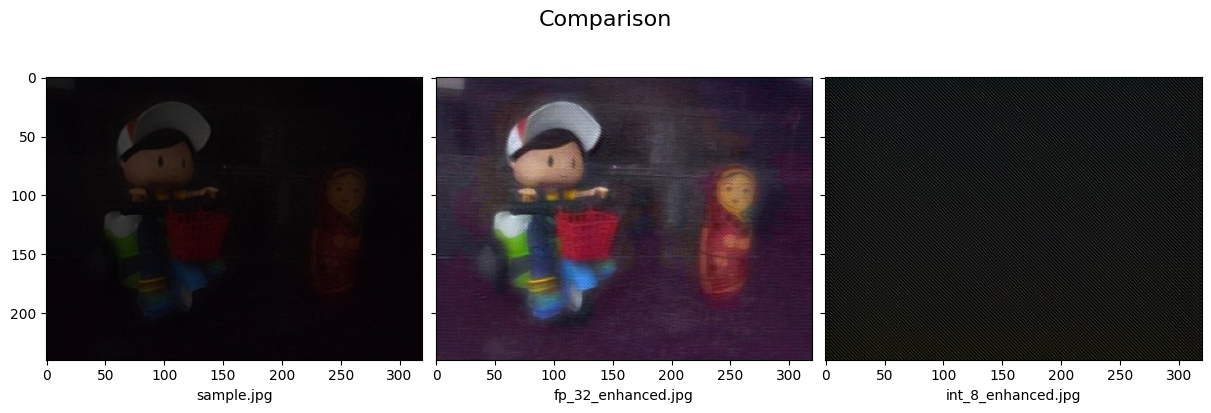

In [30]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import random as rand

def showImagesHorizontally(majors):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True,
                        sharex=True, sharey=True)
    for nn, ax in enumerate(axs.flat):
        column = majors[nn]
        column_rec_name = column.replace('\n', '_').replace(' ', '_')
        image = imread(majors[nn])
        ax.imshow(image,cmap='Greys_r',)
        ax.set_xlabel(majors[nn].split("/")[-1])
    fig.suptitle('Comparison', fontsize=16)
    plt.show()

org_img = cv2.resize(cv2.imread("Original/sample.jpg"),[320,240],interpolation=cv2.INTER_CUBIC)
cv2.imwrite("Original/sample.jpg",org_img)

folders = ["Original/sample.jpg","Results/fp_32/fp_32_enhanced.jpg","Results/int_8/int_8_enhanced.jpg"]
showImagesHorizontally(folders)